# A simple interface to compute the critical point of IPPs

## Libraries

In [1]:
import sys

import numpy as np

from subprocess import call, run

sys.path.insert(0, './pylibs')
from plot_settings import *
from model_and_potential import *
from files_handler import *
from results_analysis import *

# <center> Setting the model <center>

First, the model input parameters must be assigned. 

The particle is fully specified by three numbers, i.e., the particle radius $\sigma_c$, the patch opening angle $\gamma$ and the interaction range $\delta$. The particle radius, however, acts as length scale of the model and is automatically set to $\sigma_c = 0.5$. The model potential is fully specified by three numbers as well. i.e., the equator-equator repulsion $u_{EE}$, the patch-equator attraction $u_{EP}$ and the patch-patch repulsion $u_{PP}$. The patch-equator attraction, however, acts as energy scale of the model and is automatically set to $u_{EP} = -1.0$.

In [2]:
n_patches = 2

sigma_c = 0.5
u_EP = -1.0

In [3]:
# PARAMETER                          # NEEDS TO BE

g = float(input())                   # between 30 and 55
delta = float(input())               # Strictly larger than zero
u_EE = float(input())                # Non negative
u_PP = float(input())                # Non negative

# g = 40
# delta = 0.1
# u_EE = 0.5
# u_PP = 2.0


gamma = g * np.pi / 180
delta_half = delta / 2

print('\nPARAMETERS SET:')
print('gamma = %d°' %g)
print('delta = %g' %delta)
print('u_EE = %g' %u_EE)
print('u_PP = %g' %u_PP)

40
0.1
0.5
2.0

PARAMETERS SET:
gamma = 40°
delta = 0.1
u_EE = 0.5
u_PP = 2


In [4]:
IPP1, IPP2, a, sigma_p = build_particles(sigma_c, delta_half, gamma)

Patch extension = 40.0000 (degrees):
Patch eccentricity = 0.1572
Patch radius = 0.3928

 --- Parameters consistency ---
Eccentricity is smaller than the hard-core radius.
Patches extend outside the hard-core.

 --- Conditions for isolation of interactions ---
The EE configuration isolates the center-center interaction.
The EP configuration isolates the center-off center interaction
The PP configuration isolates the off center-off center interaction


## <center> Interaction potential \<center> 

In [5]:
W = np.zeros((3,3))                                                          # Geometric weights matrix

U = np.array([u_EE, u_EP, u_PP])                                                                             

for i, conf in enumerate(['EE', 'EP', 'PP']):
    
    IPP1, IPP2 = reference_config(IPP1, IPP2, a, sigma_c, conf)

    w = overlap_vector(IPP1, IPP2)
    W[i, :] = w   
    
e = e_from_u(W, U)        # e_EE, e_EP, e_PP

print('Interaction energies expressed in reduced units are:')
print('Equator-equator =', np.round(e[0], 6))
print('Equator-patch =', np.round(e[1], 6))
print('patch-patch =', np.round(e[2], 6))

Interaction energies expressed in reduced units are:
Equator-equator = 31.25
Equator-patch = -113.618762
patch-patch = 398.801695


In [6]:
pot = model_potential(IPP1, IPP2, e, 500)

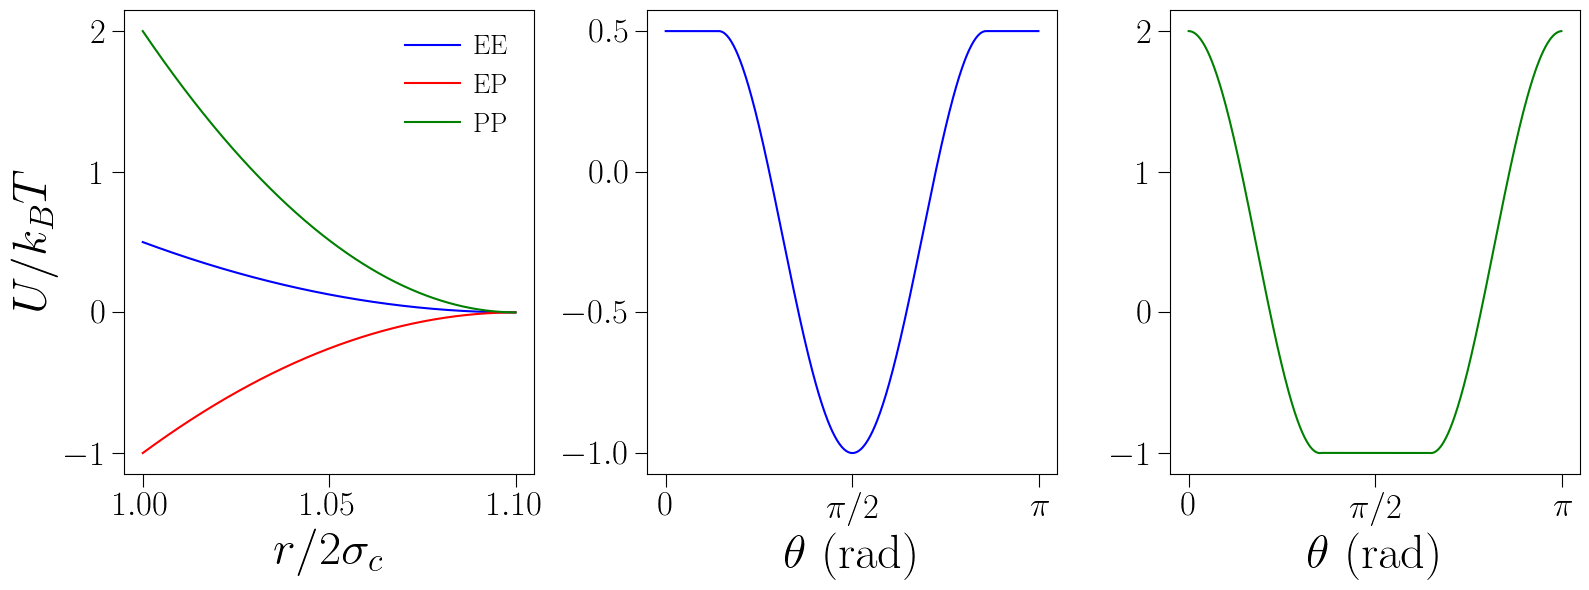

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(16, 6)

col = ['b', 'r', 'g']
for i, c in enumerate(['EE', 'EP', 'PP']):
    x, y = pot[c]
    ax[0].plot(1+x, y, c=col[i], label=c)
    
x, y = pot['radial_EE']
ax[1].plot(x, y, 'b')

x, y = pot['radial_PP']
ax[2].plot(x, y, 'g')

ax[0].set_xlabel('$r/2\\sigma_c$')
ax[1].set_xlabel('$\\theta$ (rad)')
ax[2].set_xlabel('$\\theta$ (rad)')

ax[0].set_ylabel('$U/k_B T$')

ax[1].set_xticks([0, np.pi/2, np.pi])
ax[1].set_xticklabels(['0', '$\\pi/2$', '$\\pi$'])
ax[2].set_xticks([0, np.pi/2, np.pi])
ax[2].set_xticklabels(['0', '$\\pi/2$', '$\\pi$'])

ax[0].legend()
plt.tight_layout()

## <center> Folders and file organization \<center>

We will now create a series of subfolders inside the present one. The structure of the folders is as follows:

- **Folder 1**: `res` -> This folder will contain all the results of the simulations.

- **Folder 2**: `gammaval1_deltaval2` -> This folder will contain all the results of the simulations performed using the values val1, val2 for the parameters `gamma` and `delta` respectively.


- **Folder 3**: `EEval1_PPval2` -> This folder will contain all the results of the simulations performed using the values val1, val2 for the energies `u_EE` and `u_PP` respectively. We recall that the energy `u_EP` is always set to -1 and fix the energy scale of the model.

- **Folder 4**: `Lval` -> This folder will contain all the results of the simulations performed using the value val for the system size `L`. 


- **Folder 5**: `RotMaxval1_TranMaxval2` -> This folder will contain all the results of the simulations performed using the values val1 and val2 for the maximum translation `TranMax` and maximum rotation `RotMax` of a single particle respectively.


- **Folder 6**: `Nmaxval` -> This folder  will will contain all the results of the simulations perfomed using the value val for the maximum number of particles allowed in the system. 


- **Folder 7**: StatePointFolder -> This folder will contain all the results of the simulations performed at a given state point. The state point is determined by the temperature `T` and the chemical potential `mu`, so the folder will be of the form `Tval_muval`.

- **Folder 7.x**: `confs_numval` -> This folder will contain the file used as initial condition of the simulation, the last configuration observed in the simulation and, depending on the choice made by the user, a file containig multiple configuration observed during the run. As each state point can be simulated more than once to enhance the sampling, there may be several configuration folders, each associated to a specific simulation of the given state point. If, for example, three simulations are performed, the folder 7 specifying the state point will contain the folders `confs_num1`, `confs_num2` and `confs_num3`; each will contain the files `init_cond.txt`, `last.txt` and, possibly `confs_all.txt`.

In [8]:
L = 8 

RotMax = 0.04
TranMax = 0.02                    # RotMax / 2

N_max = 350

In [9]:
MCsteps = int(5e7)                   # Total numer of MC steps. Remember: 1 MC step = Nmax moves
print_every = 1000                   # Save number of particles and energy every print_every steps
save_every = 10000                   # Save a configuration every save_every steps


# If you want the simulations to stop after a certain amount of time, set these parameters accordingly

Ndays = 14                           # Maximum number of days the simulation is allowed to run                 
Nhours = 0                           # Maximum number of hours the simulation is allowed to run                 
Nminutes = 0                         # Maximum number of minutes the simulation is allowed to run

# Set to 1 if the simulation must restart from an old configuration
restart = 0

# Number of parallel simulations to be performed, given a single state point
Nparal = 12

# Number of cores available for the simulations
Ncores = 12

# Seed for random numbers generator
seed = np.random.randint(1, 2147483645, Nparal)

In [10]:
T = 0.1031
mu = -0.399

In [11]:
Par = (g, delta_half, u_EE, u_PP, L, RotMax, TranMax, N_max)

In [12]:
fold = build_directories(Par)
infold = build_inner_directories(fold, T, mu, Nparal)

In [13]:
Par = [gamma, delta_half, sigma_p, a, n_patches, e[0], e[1], e[2], L, RotMax, TranMax, N_max]  # n_patches = ?

MC_settings = [MCsteps, print_every, save_every, Ndays, Nhours, Nminutes, restart, seed]

## <center> Running the simulation <center>

In [14]:
import sys, importlib
importlib.reload(sys.modules['files_handler'])

<module 'files_handler' from './pylibs/files_handler.py'>

In [15]:
rho_0 = 0.2                                # Initial density. Must be < 0.7
N0 = int(rho_0 * L * L * L)

for j in range(Nparal):
    single_input_file(Par, MC_settings, T, N0, mu, infold, j+1)

In [16]:
executers_generator(T, mu, Nparal, Ncores, fold, 'generator')

In [17]:
_ = run(['chmod', 'u+x', 'executer.sh'])

In [18]:
_ = call('./executer.sh')

In [19]:
executers_generator(T, mu, Nparal, Ncores, fold, 'IPP')

In [20]:
_ = run(['chmod', 'u+x', 'executer.sh'])

In [21]:
_ = call('./executer.sh')

## <center> Simulation results <center>

In [14]:
equilibration = int(2.5e6)

MC, ind = load_results(infold, Nparal, equilibration)

The average acceptance rate after equilibration of run 1 is 0.131
The average acceptance rate after equilibration of run 2 is 0.124
The average acceptance rate after equilibration of run 3 is 0.134
The average acceptance rate after equilibration of run 4 is 0.143
The average acceptance rate after equilibration of run 5 is 0.127
The average acceptance rate after equilibration of run 6 is 0.132
The average acceptance rate after equilibration of run 7 is 0.121
The average acceptance rate after equilibration of run 8 is 0.122
The average acceptance rate after equilibration of run 9 is 0.193
The average acceptance rate after equilibration of run 10 is 0.159
The average acceptance rate after equilibration of run 11 is 0.131
The average acceptance rate after equilibration of run 12 is 0.141

The total acceptance rate after equilibration is 0.138


In [15]:
running_time(MC, infold, Nparal)

RUN 1
Runtime: 0 - 9:16:22
Average number of MC steps per second: 1497.81

RUN 2
Runtime: 0 - 9:24:26
Average number of MC steps per second: 1476.41

RUN 3
Runtime: 0 - 9:18:6
Average number of MC steps per second: 1493.16

RUN 4
Runtime: 0 - 9:4:43
Average number of MC steps per second: 1529.80

RUN 5
Runtime: 0 - 9:21:49
Average number of MC steps per second: 1483.28

RUN 6
Runtime: 0 - 9:12:54
Average number of MC steps per second: 1507.16

RUN 7
Runtime: 0 - 9:26:51
Average number of MC steps per second: 1470.07

RUN 8
Runtime: 0 - 9:26:48
Average number of MC steps per second: 1470.20

RUN 9
Runtime: 0 - 8:16:32
Average number of MC steps per second: 1678.30

RUN 10
Runtime: 0 - 8:49:10
Average number of MC steps per second: 1574.75

RUN 11
Runtime: 0 - 9:17:8
Average number of MC steps per second: 1495.75

RUN 12
Runtime: 0 - 9:2:29
Average number of MC steps per second: 1536.10



In [16]:
pdfs = all_histos_from_one_conf(MC['data'])

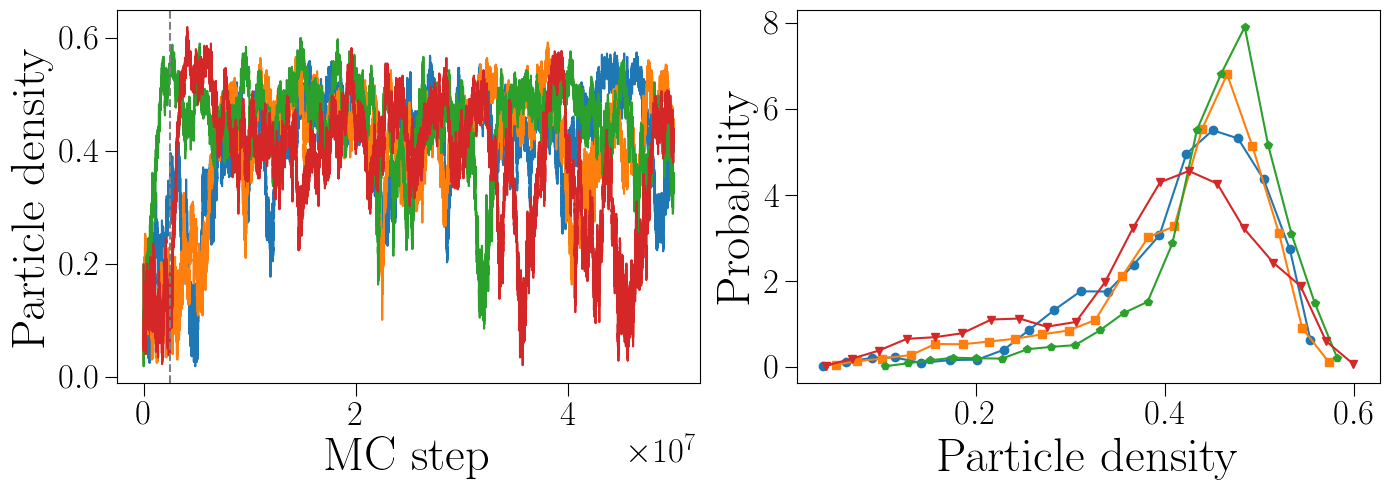

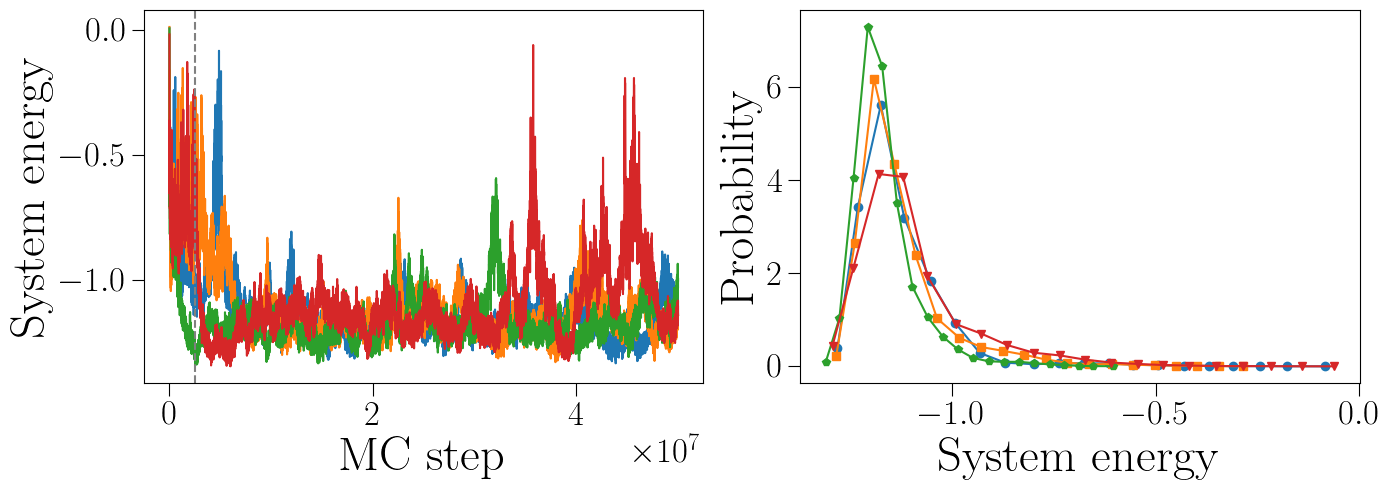

In [17]:
single_run_plot(MC['TS'], pdfs, ind, L**3)

## <center> Fitting <center>

In [38]:
Tmin = T - 0.001
Tmax = T + 0.001
MUmin = mu - 0.01
MUmax = mu + 0.01

Bounds = ((MUmin, MUmax),
         (1.0 / Tmax, 1.0 / Tmin),
         (0, 1))

itr = 4
n_pts = 512
minimize_options = {'method' : 'L-BFGS-B', 'disp': None, 'maxls': 20, 'iprint': -1, 'gtol': 1e-14,\
                    'eps': 1e-14, 'maxiter': 100000, 'ftol': 1e-18, 'maxcor': 10, 'maxfun': 100000}

shgo_settings = {
    'minimizer_kwargs' : minimize_options,
    'Polybounds' : Bounds,
    'itr' : itr,
    'n' : n_pts
}


In [39]:
beta = 1. / T

N, E = MC['data']['n'], MC['data']['e']

b = int(max(N) - min(N)) - 1

not_to_fit = ([N, E, beta, mu, b])

Fit = optimize.shgo(target_tmp, Bounds, args=(not_to_fit, ), iters=itr,\
                 minimizer_kwargs=minimize_options, n=n_pts, sampling_method='simplicial')

In [40]:
mu_prime, beta_prime, s = Fit['x']
T_prime = 1/beta_prime

In [41]:
Tmin = T_prime - 0.0005
Tmax = T_prime + 0.0005
MUmin = mu_prime - 0.005
MUmax = mu_prime + 0.005

Bounds = ((MUmin, MUmax),
         (1.0 / Tmax, 1.0 / Tmin),
         (0, 1))

itr = 4
n_pts = 512
minimize_options = {'method' : 'L-BFGS-B', 'disp': None, 'maxls': 20, 'iprint': -1, 'gtol': 1e-14,\
                    'eps': 1e-14, 'maxiter': 100000, 'ftol': 1e-18, 'maxcor': 10, 'maxfun': 100000}

shgo_settings = {
    'minimizer_kwargs' : minimize_options,
    'Polybounds' : Bounds,
    'itr' : itr,
    'n' : n_pts
}


In [42]:
beta = 1. / T

N, E = MC['data']['n'], MC['data']['e']

b = int(max(N) - min(N)) - 1

not_to_fit = ([N, E, beta, mu, b])

Fit = optimize.shgo(target, Bounds, args=(not_to_fit, ), iters=itr,\
                 minimizer_kwargs=minimize_options, n=n_pts, sampling_method='simplicial')

In [43]:
mu_prime, beta_prime, s = Fit['x']
T_prime = 1/beta_prime

In [44]:
c, _, _, M, PM, Ising = chi(mu_prime, beta_prime, s, N, E, beta, mu, b)

N_prime, PN_prime, _ = single_reweighted_hist(mu_prime, beta_prime, N, N, E, beta, mu, b)
E_prime, PE_prime, _ = single_reweighted_hist(mu_prime, beta_prime, E, N, E, beta, mu, b)

Nx, PN, _ = lin_hist(N, b)
Ex, PE, _ = lin_hist(E, b)

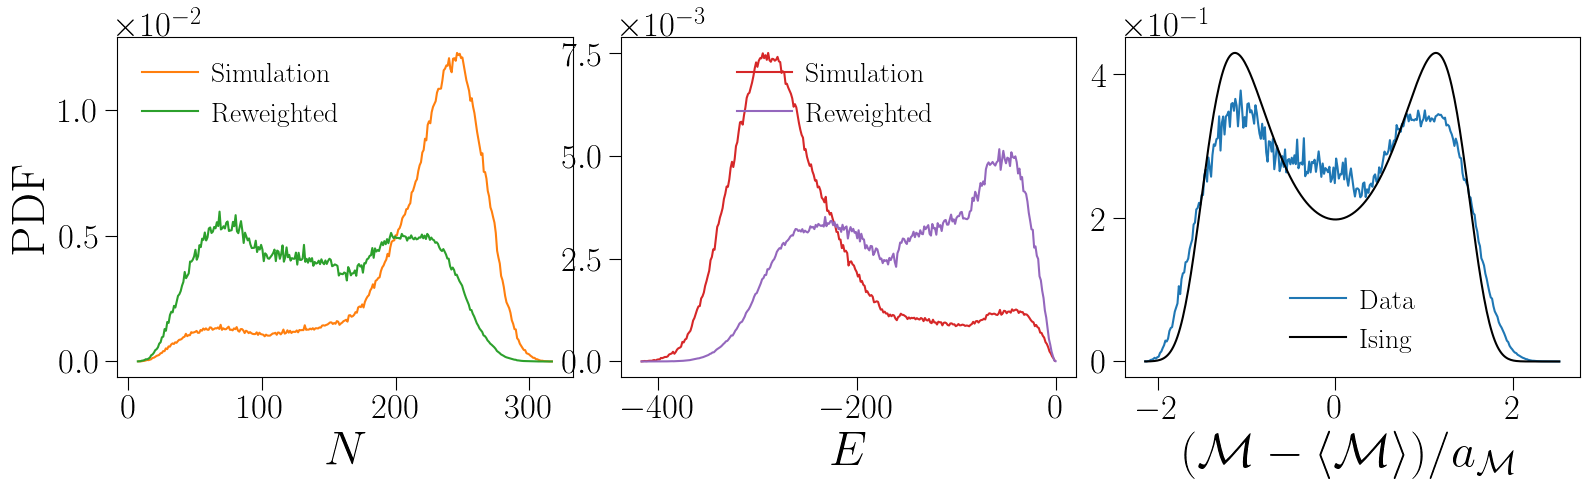

In [45]:
fig, ax = plt.subplots(figsize=(16, 5), ncols=3)

ax[2].plot(M, PM, label='Data')
ax[2].plot(M, Ising, '-k', label='Ising')

ax[0].plot(Nx, PN, c='tab:orange', label='Simulation')
ax[0].plot(N_prime, PN_prime, c='tab:green', label='Reweighted')

ax[1].plot(Ex, PE, c='tab:red', label='Simulation')
ax[1].plot(E_prime, PE_prime, c='tab:purple', label='Reweighted')

ax[0].legend()
ax[1].legend(loc='upper left', bbox_to_anchor=(0.2, 1))
ax[2].legend()

ax[2].set_xlabel('$(\\mathcal{M} - \\langle \\mathcal{M} \\rangle) / a_{\\mathcal{M}}$')
ax[0].set_xlabel('$N$')
ax[1].set_xlabel('$E$')
ax[0].set_ylabel('PDF')

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(-1,4))
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-1,4))
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(-1,1))

plt.tight_layout()

In [46]:
print('Simulation temperature:', T)
print('Critical temperature:', T_prime)

print('\nSimulation chemical potential:', mu)
print('Critical chemical potential:', mu_prime)

print('\nMixing parameter:', s)
print('Chi square', c)

Simulation temperature: 0.1031
Critical temperature: 0.10384087570663815

Simulation chemical potential: -0.398
Critical chemical potential: -0.3926474857823316

Mixing parameter: 0.12499999957523565
Chi square 0.7988087060369258
